In [1]:
import pydicom
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
from shutil import copyfile
import seaborn as sns
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
rsna_labels=pd.read_csv('C:\\Chest X-rays\\Datasets\\RSNA_Pneumonia_Dataset\\stage_2_train_labels.csv')
rsna_labels.head(3)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0


In [4]:
def get_RSNA_dataframe(xray_folder):
    data=[]
    for patient_id in os.listdir(xray_folder):
        xray_data=[]
        dcm_file=xray_folder+patient_id
        dcm_data = pydicom.read_file(dcm_file)
        label=rsna_labels[rsna_labels['patientId']==patient_id.replace(".dcm","")]['Target'].values[0]
        xray_data=[patient_id.replace(".dcm",""),patient_id,patient_id.replace(".dcm",".png"),dcm_data.PatientSex,dcm_data.PatientAge,dcm_data.ViewPosition,label]
        data.append(xray_data)
    rsna_df=pd.DataFrame(data=data,columns=['patient_id','dicom','xray','sex','age','view_position','label'])   
    return rsna_df

In [5]:
def convert_dcm_png(src,target):
    dcm_file=src
    dcm_data = pydicom.read_file(dcm_file)
    img = dcm_data.pixel_array
    cv2.imwrite(target,img)

In [6]:
%%time
xray_folder="C:\\Chest X-rays\\Datasets\\RSNA_Pneumonia_Dataset\\stage_2_train_images\\"
rsna_data=get_RSNA_dataframe(xray_folder)

Wall time: 1min 47s


In [7]:
rsna_data.head(5)

,patient_id,dicom,xray,sex,age,view_position,label
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm,0004cfab-14fd-4e49-80ba-63a80b6bddd6.png,F,51,PA,0
1,000924cf-0f8d-42bd-9158-1af53881a557,000924cf-0f8d-42bd-9158-1af53881a557.dcm,000924cf-0f8d-42bd-9158-1af53881a557.png,F,19,AP,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,000db696-cf54-4385-b10b-6b16fbb3f985.dcm,000db696-cf54-4385-b10b-6b16fbb3f985.png,F,25,AP,1
3,000fe35a-2649-43d4-b027-e67796d412e0,000fe35a-2649-43d4-b027-e67796d412e0.dcm,000fe35a-2649-43d4-b027-e67796d412e0.png,M,40,AP,1
4,001031d9-f904-4a23-b3e5-2c088acd19c6,001031d9-f904-4a23-b3e5-2c088acd19c6.dcm,001031d9-f904-4a23-b3e5-2c088acd19c6.png,M,57,PA,1


In [8]:
rsna_df=shuffle(rsna_data)
rsna_df['label_description']=rsna_df['label'].map({0:'Not Pneumonia',1:'Pneumonia'})
rsna_df['age_group']=pd.cut(rsna_df['age'].astype('int'),[1,20,30,40,50,60,90,100],right=True)

In [9]:
pneumonia_df=rsna_df[rsna_df['label']==1].sample(n=6000,random_state=1)
pneumonia_df.shape

(6000, 9)

In [10]:
nofinding_df=rsna_df[rsna_df['label']==0].sample(n=6000, random_state=1)
nofinding_df.shape

(6000, 9)

In [11]:
rsna_final_df=pd.concat([pneumonia_df,nofinding_df])
rsna_final_df.shape

(12000, 9)

In [12]:
rsna_final_df=shuffle(rsna_final_df)
rsna_final_df.head(5)

,patient_id,dicom,xray,sex,age,view_position,label,label_description,age_group
2612,2ae3e7ba-a0fe-4f0a-96db-d337714aa657,2ae3e7ba-a0fe-4f0a-96db-d337714aa657.dcm,2ae3e7ba-a0fe-4f0a-96db-d337714aa657.png,M,23,PA,1,Pneumonia,"(20, 30]"
13661,8e9b628f-2e78-4ec1-91ee-3a8e65357ea9,8e9b628f-2e78-4ec1-91ee-3a8e65357ea9.dcm,8e9b628f-2e78-4ec1-91ee-3a8e65357ea9.png,M,64,AP,0,Not Pneumonia,"(60, 90]"
407,06d5a58d-baf1-4937-bfc3-00db1fb2b1be,06d5a58d-baf1-4937-bfc3-00db1fb2b1be.dcm,06d5a58d-baf1-4937-bfc3-00db1fb2b1be.png,M,9,AP,1,Pneumonia,"(1, 20]"
14529,9673d5f3-fc1c-49bc-902a-81ff14db1da0,9673d5f3-fc1c-49bc-902a-81ff14db1da0.dcm,9673d5f3-fc1c-49bc-902a-81ff14db1da0.png,M,23,AP,1,Pneumonia,"(20, 30]"
2839,3036ca10-8d42-4749-81e2-8ed235a6a567,3036ca10-8d42-4749-81e2-8ed235a6a567.dcm,3036ca10-8d42-4749-81e2-8ed235a6a567.png,M,39,PA,1,Pneumonia,"(30, 40]"


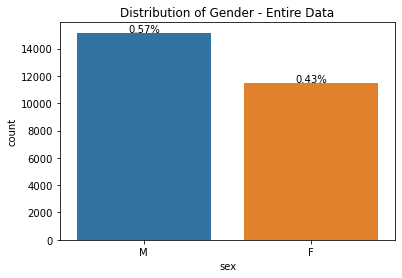

In [13]:
total = float(len(rsna_data)) # one person per row
ax = sns.countplot(x='sex',data=rsna_data,order=['M','F']);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/total),
            ha="center")
plt.title("Distribution of Gender - Entire Data")    
plt.show()

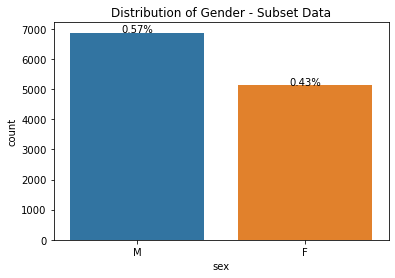

In [14]:
total = float(len(rsna_final_df)) # one person per row
ax = sns.countplot(x='sex',data=rsna_final_df,order=['M','F']);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/total),
            ha="center")
plt.title("Distribution of Gender - Subset Data")    
plt.show()

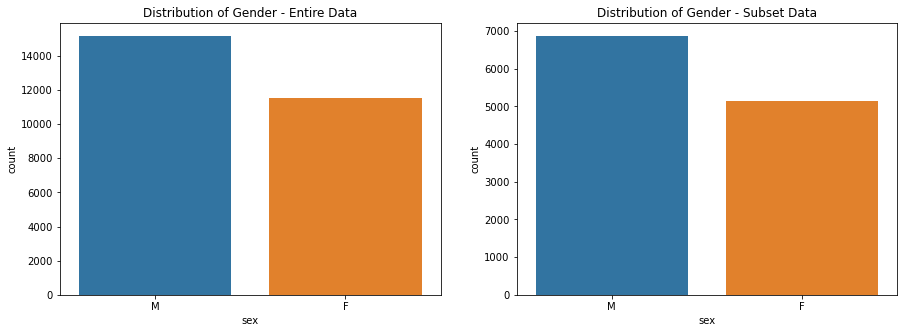

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(x='sex',data=rsna_data,order=['M','F']);
plt.title('Distribution of Gender - Entire Data');
plt.subplot(1,2,2)
sns.countplot(x='sex',data=rsna_final_df,order=['M','F']);
plt.title('Distribution of Gender - Subset Data');

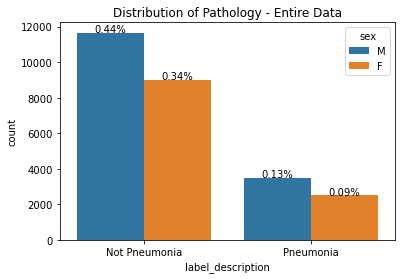

In [16]:
total = float(len(rsna_df)) # one person per row
ax = sns.countplot(x='label_description',hue='sex',data=rsna_df,order=['Not Pneumonia','Pneumonia']);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/total),
            ha="center")
plt.title("Distribution of Pathology - Entire Data")    
plt.show()

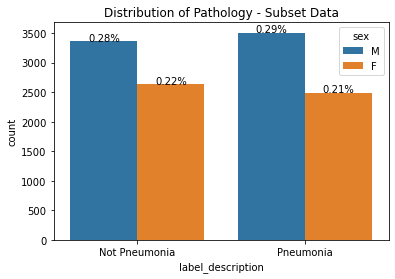

In [17]:
total = float(len(rsna_final_df)) # one person per row
ax = sns.countplot(x='label_description',hue='sex',data=rsna_final_df,order=['Not Pneumonia','Pneumonia']);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/total),
            ha="center")
plt.title("Distribution of Pathology - Subset Data")    
plt.show()

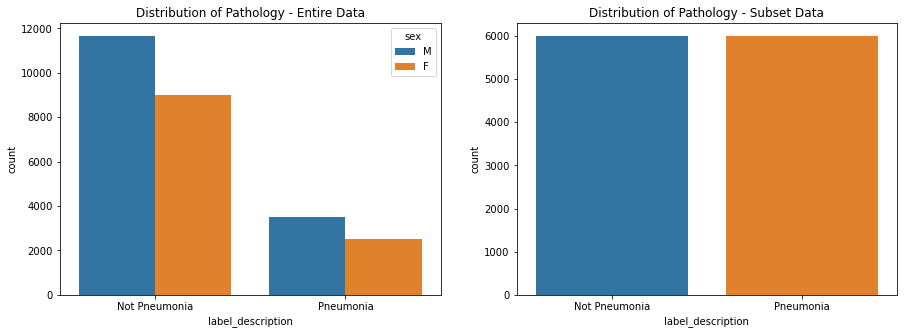

In [41]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(x='label_description',hue='sex',data=rsna_df,order=['Not Pneumonia','Pneumonia']);
plt.title('Distribution of Pathology - Entire Data');
plt.subplot(1,2,2)
sns.countplot(x='label_description',data=rsna_final_df,order=['Not Pneumonia','Pneumonia']);
plt.title('Distribution of Pathology - Subset Data');

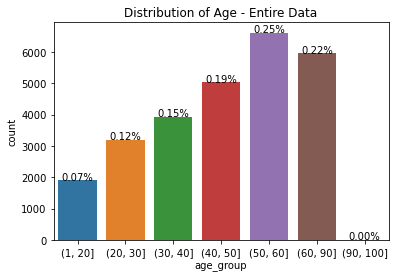

In [19]:
total = float(len(rsna_df)) # one person per row
ax = sns.countplot(x='age_group',data=rsna_df);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/total),
            ha="center")
plt.title("Distribution of Age - Entire Data")    
plt.show()

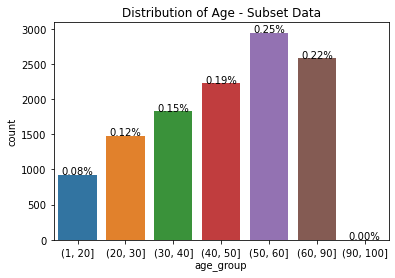

In [20]:
total = float(len(rsna_final_df)) # one person per row
ax = sns.countplot(x='age_group',data=rsna_final_df);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/total),
            ha="center")
plt.title("Distribution of Age - Subset Data")    
plt.show()

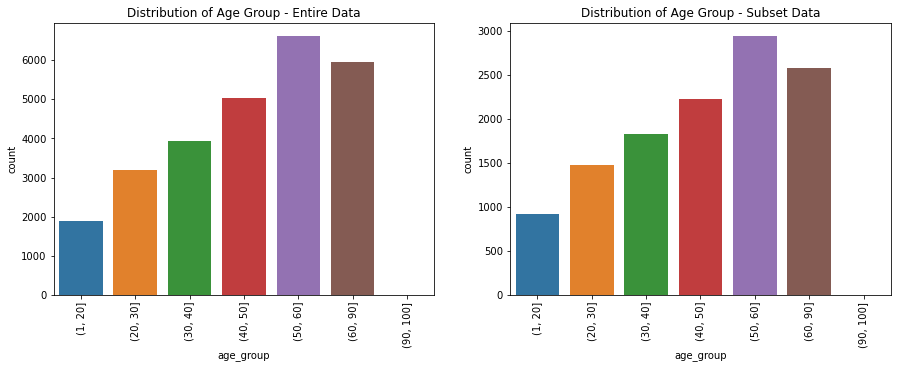

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(x='age_group',data=rsna_df);
plt.title('Distribution of Age Group - Entire Data');
plt.xticks(rotation=90)
plt.subplot(1,2,2)
sns.countplot(x='age_group',data=rsna_final_df);
plt.title('Distribution of Age Group - Subset Data');
plt.xticks(rotation=90);

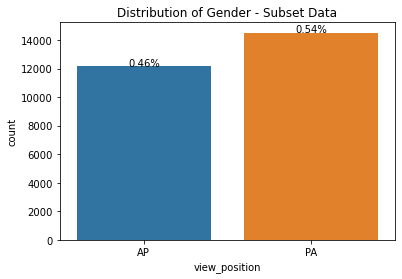

In [22]:
total = float(len(rsna_df)) # one person per row
ax = sns.countplot(x='view_position',data=rsna_df,order=['AP','PA']);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/total),
            ha="center")
plt.title("Distribution of Gender - Subset Data")    
plt.show()

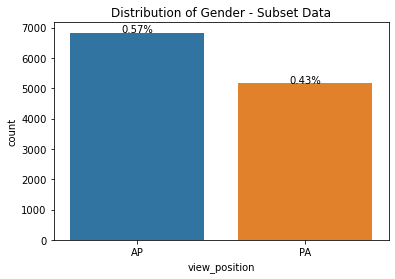

In [23]:
total = float(len(rsna_final_df)) # one person per row
ax = sns.countplot(x='view_position',data=rsna_final_df,order=['AP','PA']);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/total),
            ha="center")
plt.title("Distribution of Gender - Subset Data")    
plt.show()

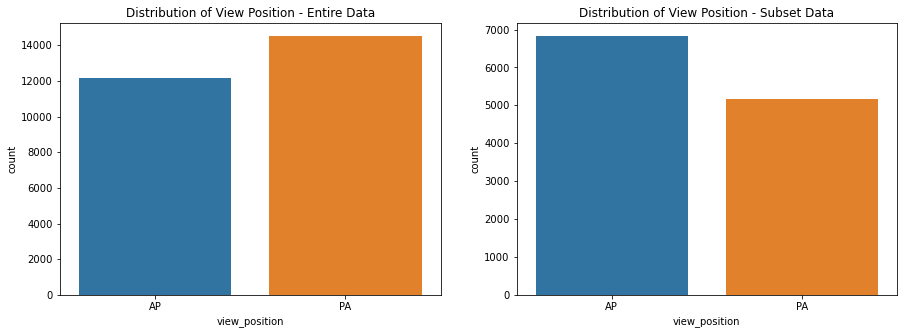

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(x='view_position',data=rsna_df,order=['AP','PA']);
plt.title('Distribution of View Position - Entire Data');
plt.subplot(1,2,2)
sns.countplot(x='view_position',data=rsna_final_df,order=['AP','PA']);
plt.title('Distribution of View Position - Subset Data');

In [25]:
rsna_final_df.head()

,patient_id,dicom,xray,sex,age,view_position,label,label_description,age_group
2612,2ae3e7ba-a0fe-4f0a-96db-d337714aa657,2ae3e7ba-a0fe-4f0a-96db-d337714aa657.dcm,2ae3e7ba-a0fe-4f0a-96db-d337714aa657.png,M,23,PA,1,Pneumonia,"(20, 30]"
13661,8e9b628f-2e78-4ec1-91ee-3a8e65357ea9,8e9b628f-2e78-4ec1-91ee-3a8e65357ea9.dcm,8e9b628f-2e78-4ec1-91ee-3a8e65357ea9.png,M,64,AP,0,Not Pneumonia,"(60, 90]"
407,06d5a58d-baf1-4937-bfc3-00db1fb2b1be,06d5a58d-baf1-4937-bfc3-00db1fb2b1be.dcm,06d5a58d-baf1-4937-bfc3-00db1fb2b1be.png,M,9,AP,1,Pneumonia,"(1, 20]"
14529,9673d5f3-fc1c-49bc-902a-81ff14db1da0,9673d5f3-fc1c-49bc-902a-81ff14db1da0.dcm,9673d5f3-fc1c-49bc-902a-81ff14db1da0.png,M,23,AP,1,Pneumonia,"(20, 30]"
2839,3036ca10-8d42-4749-81e2-8ed235a6a567,3036ca10-8d42-4749-81e2-8ed235a6a567.dcm,3036ca10-8d42-4749-81e2-8ed235a6a567.png,M,39,PA,1,Pneumonia,"(30, 40]"


In [27]:
rsna_final_df.to_csv('RSNA_Subset_Pneumonia.csv')
rsna_data.to_csv('RSNA_Pneumonia.csv')

In [28]:
pneumonia_list=list(rsna_final_df[rsna_final_df['label']==1]['dicom'].values)
nofinding_list=list(rsna_final_df[rsna_final_df['label']==0]['dicom'].values)

In [29]:
pneumonia_train=pneumonia_list[0:4200]
nofinding_train=nofinding_list[0:4200]
pneumonia_val=pneumonia_list[4200:5100]
nofinding_val=nofinding_list[4200:5100]
pneumonia_test=pneumonia_list[5100:6000]
nofinding_test=nofinding_list[5100:6000]

In [33]:
train_df=pd.DataFrame(data=pneumonia_train+nofinding_train,columns=['filename'])
train_df.to_csv('RSNA_Pneumonia_Train.csv')
val_df=pd.DataFrame(data=pneumonia_val+nofinding_val,columns=['filename'])
val_df.to_csv('RSNA_Pneumonia_Val.csv')
test_df=pd.DataFrame(data=pneumonia_test+nofinding_test,columns=['filename'])
test_df.to_csv('RSNA_Pneumonia_Test.csv')

In [35]:
dest=r"C:\\Chest X-rays\\Datasets\\RSNA_Pneumonia\\Train\\Pneumonia"
for img in pneumonia_train:
    src="C:\\Chest X-rays\\Datasets\\RSNA_Pneumonia_Dataset\\stage_2_train_images\\"+img
    dst=(dest+"\\"+img).replace(".dcm",".png")
    convert_dcm_png(src,dst)

In [36]:
dest=r"C:\\Chest X-rays\\Datasets\\RSNA_Pneumonia\\Train\\Not Pneumonia"
for img in nofinding_train:
    src="C:\\Chest X-rays\\Datasets\\RSNA_Pneumonia_Dataset\\stage_2_train_images\\"+img
    dst=(dest+"\\"+img).replace(".dcm",".png")
    convert_dcm_png(src,dst)

In [37]:
dest=r"C:\\Chest X-rays\\Datasets\\RSNA_Pneumonia\\Val\\Pneumonia"
for img in pneumonia_val:
    src="C:\\Chest X-rays\\Datasets\\RSNA_Pneumonia_Dataset\\stage_2_train_images\\"+img
    dst=(dest+"\\"+img).replace(".dcm",".png")
    convert_dcm_png(src,dst)

In [38]:
dest=r"C:\\Chest X-rays\\Datasets\\RSNA_Pneumonia\\Val\\Not Pneumonia"
for img in nofinding_val:
    src="C:\\Chest X-rays\\Datasets\\RSNA_Pneumonia_Dataset\\stage_2_train_images\\"+img
    dst=(dest+"\\"+img).replace(".dcm",".png")
    convert_dcm_png(src,dst)

In [39]:
dest=r"C:\\Chest X-rays\\Datasets\\RSNA_Pneumonia\\Test\\Pneumonia"
for img in pneumonia_test:
    src="C:\\Chest X-rays\\Datasets\\RSNA_Pneumonia_Dataset\\stage_2_train_images\\"+img
    dst=(dest+"\\"+img).replace(".dcm",".png")
    convert_dcm_png(src,dst)

In [40]:
dest=r"C:\\Chest X-rays\\Datasets\\RSNA_Pneumonia\\Test\\Not Pneumonia"
for img in nofinding_test:
    src="C:\\Chest X-rays\\Datasets\\RSNA_Pneumonia_Dataset\\stage_2_train_images\\"+img
    dst=(dest+"\\"+img).replace(".dcm",".png")
    convert_dcm_png(src,dst)

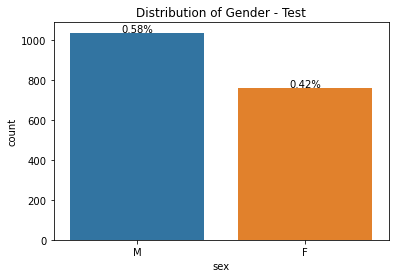

In [51]:
total = float(len(rsna_final_df[rsna_final_df['dicom'].isin(test_df['filename'])])) # one person per row
ax = sns.countplot(x='sex',data=rsna_final_df[rsna_final_df['dicom'].isin(test_df['filename'])],order=['M','F']);
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/total),
            ha="center")
plt.title("Distribution of Gender - Test")    
plt.show()